# ASUM

In [62]:
import os
import re

import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from reviews.config import processed_data_dir, asum_input_dir, asum_output_dir
from reviews.preprocess import preprocess
from reviews.models import asum

In [63]:
# read data
reviews_df = pd.read_json(
    processed_data_dir / "reviews_digital_cameras.json.gz", orient="records"
)
reviews_df.dropna(inplace=True)
reviews_df.drop_duplicates(inplace=True)

# reviews_df = reviews_df.sample(100) # subset

reviews_df.reset_index(inplace=True, drop=True)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87205 entries, 0 to 87204
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   overall    87205 non-null  int64         
 1   vote       87205 non-null  int64         
 2   asin       87205 non-null  object        
 3   text       87205 non-null  object        
 4   summary    87205 non-null  object        
 5   timestamp  87205 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 4.0+ MB


## Preprocessing

In [64]:
# apply preprocessing
reviews_df["tokens"] = reviews_df["text"].apply(lambda x: preprocess(x))

/home/saiteki-kai/MEGA/プロジェクト/進行中/data-analytics/venv/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [66]:
tokens = [word for doc in reviews_df["tokens"] for sent in doc for word in sent]
c = Counter(tokens)

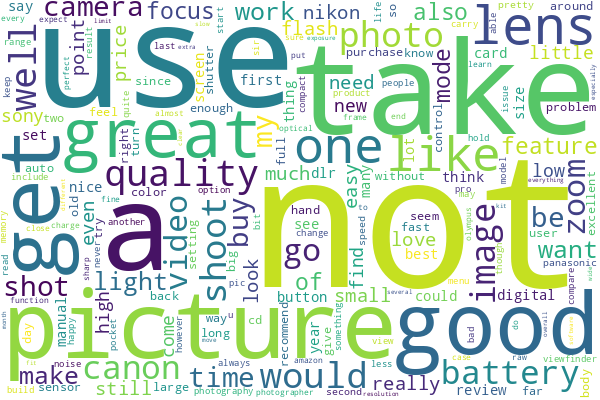

In [67]:
# generate the word cloud
w = WordCloud(
    collocations=False,
    prefer_horizontal=0.6,
    width=600,
    height=400,
    background_color="white",
).fit_words(c)
w.to_image()

In [68]:
vocabulary = dict((e, i) for i, e in enumerate(set(tokens)))
print(len(vocabulary))

36847


## Generate data for ASUM

In [ ]:
with open(asum_input_dir / "WordList.txt", "w") as f:
    for word in vocabulary:
        f.write(f"{word}\n")

In [ ]:
sentence_list = asum_input_dir / "BagOfSentences.txt"

if os.path.exists(sentence_list):
    os.remove(sentence_list)

with open(sentence_list, "a") as f:
    for doc in reviews_df["tokens"]:
        f.write(f"{len(doc)}\n")
        for tokens in doc:
            indexes = " ".join([str(vocabulary[t]) for t in tokens])
            f.write(f"{indexes}\n")

In [ ]:
asum("0.1", "0.001/0.1/0", "1/1", "5", iterations="1000")

## Print Values

In [5]:
df = pd.read_csv(
    asum_output_dir / "STO2-T5-S2(2)-A0.1-B0.001,0.1,0.0-G1.0,1.0-I500-ProbWords.csv"
)


def map_topic_sentiment(column_name):
    if "Unnamed" in column_name:
        return None

    values = column_name.split("-")
    return {
        "sentiment": int(values[0][1]),
        "topic": int(values[1][1]),
        "colname": column_name,
    }


columns = df.columns.map(map_topic_sentiment)

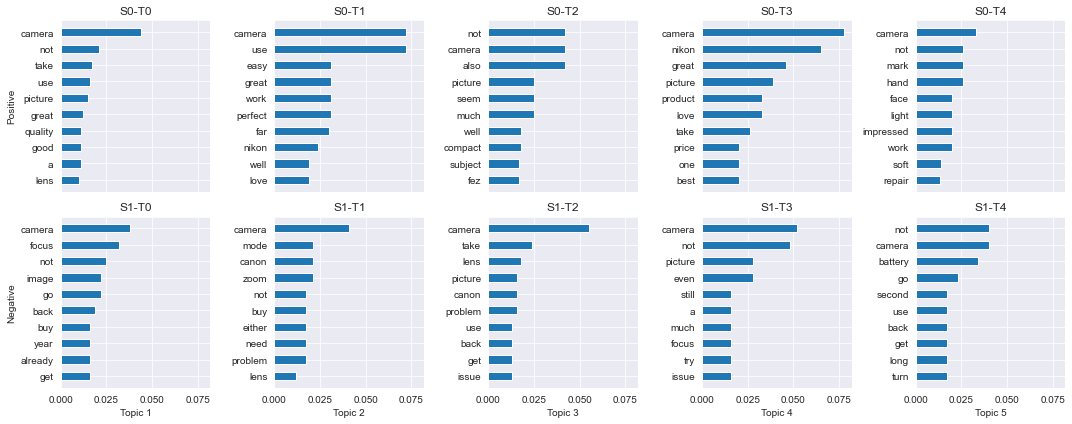

In [61]:
def get_word_weight(text):
    match = re.match("(\w+)\s+\((.*?)\)", text)
    word, weight = match.groups()
    return word, float(weight)


n_topics = 5
n_top_words = 10

fig, axes = plt.subplots(2, n_topics, figsize=(15, 6), sharex="all")
axes = axes.flatten()

for idx, item in enumerate(columns):
    if item is None:
        continue

    ax = axes[idx]
    words = df[item["colname"]][:n_top_words]
    weights = list(map(list, zip(*words.map(get_word_weight))))

    weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
    weights.sort_values("weights", inplace=True)

    ax.barh(weights["names"], weights["weights"], height=0.5)
    ax.set_title(item["colname"])

    if idx > n_topics - 1:
        ax.set_xlabel(f"Topic {item['topic'] + 1}")

    if idx == 0 or idx == n_topics:
        ax.set_ylabel("Positive" if item["sentiment"] == 0 else "Negative")
fig.tight_layout()

<AxesSubplot:ylabel='None'>

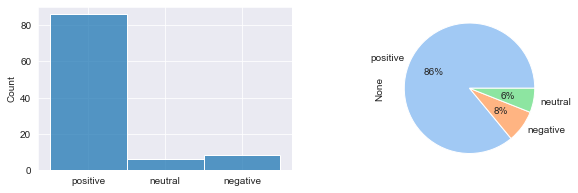

In [60]:
import seaborn as sns

pi_df = pd.read_csv(
    asum_output_dir / "STO2-T5-S2(2)-A0.1-B0.001,0.1,0.0-G1.0,1.0-I500-Pi.csv",
    header=None,
)

doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == 0 else "negative")
doc_sentiment.loc[pi_df[0] == 0.5] = "neutral"

reviews_df["sentiment"] = doc_sentiment

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(x=doc_sentiment, ax=axes[0])

counts = doc_sentiment.value_counts()
counts.plot(
    ax=axes[1], kind="pie", colors=sns.color_palette("pastel")[0:7], autopct="%.0f%%"
)

In [11]:
theta_df = pd.read_csv(
    asum_output_dir / "STO2-T5-S2(2)-A0.1-B0.001,0.1,0.0-G1.0,1.0-I500-Theta.csv"
)
theta_df.drop(columns=["Unnamed: 10"], inplace=True)

mask = theta_df >= 0.3
mask = mask.apply(lambda x: list(mask.columns[x]), axis=1)

reviews_df["topics"] = mask.apply(lambda x: list(map(map_topic_sentiment, x)))

In [12]:
reviews_df.to_json(asum_output_dir / "topics.json", orient="records")